In [ ]:
from langchain_tavily import TavilySearch
from dotenv import load_dotenv
import os
from loguru import logger

load_dotenv()
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")

web_search_tool = TavilySearch(max_results=2)
tools = [web_search_tool]

In [10]:
from langchain import hub
from langchain.chat_models import init_chat_model

from langgraph.prebuilt import create_react_agent

# Choose the LLM that will drive the agent
llm = init_chat_model(
    "qwen2.5:7b",
    model_provider="ollama",
    temperature=0,
)
prompt = "You are a helpful assistant."
agent_executor = create_react_agent(llm, tools, prompt=prompt)

In [4]:
agent_executor.invoke({"messages": [("user", "who is the winnner of the us open")]})

{'messages': [HumanMessage(content='who is the winnner of the us open', additional_kwargs={}, response_metadata={}, id='e1aec71b-7cf2-4cca-a474-4a5b7971326d'),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen2.5:7b', 'created_at': '2025-06-09T05:39:26.396271Z', 'done': True, 'done_reason': 'stop', 'total_duration': 16432733208, 'load_duration': 748327875, 'prompt_eval_count': 951, 'prompt_eval_duration': 12949994000, 'eval_count': 30, 'eval_duration': 2721960042, 'model_name': 'qwen2.5:7b'}, id='run--53f2718b-850e-413c-933d-b6c684309468-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'us open winner', 'topic': 'general'}, 'id': 'ca81c1c8-a6a2-4712-a000-1977bfef181f', 'type': 'tool_call'}], usage_metadata={'input_tokens': 951, 'output_tokens': 30, 'total_tokens': 981}),
  ToolMessage(content='{"query": "us open winner", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "U.S. Open Winners: The Full List of Golf Cha

In [5]:
import operator
from typing import Annotated, List, Tuple
from typing_extensions import TypedDict


class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str

In [6]:
from pydantic import BaseModel, Field


class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order"
    )

In [7]:
from langchain_core.prompts import ChatPromptTemplate
from langchain.chat_models import init_chat_model

plannerllm = init_chat_model(
    "qwen2.5:7b",
    model_provider="ollama",
    temperature=0,
)

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.""",
        ),
        ("placeholder", "{messages}"),
    ]
)
planner = planner_prompt | plannerllm.with_structured_output(Plan)

In [8]:
planner.invoke(
    {
        "messages": [
            ("user", "what is the hometown of the current Australia open winner?")
        ]
    }
)

Plan(steps=['Identify the current winner of the Australian Open.', 'Find the hometown or birthplace of the identified winner.'])

In [9]:
from typing import Union


class Response(BaseModel):
    """Response to user."""

    response: str


class Act(BaseModel):
    """Action to perform."""

    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )


replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan."""
)

replannerllm = init_chat_model(
    "qwen2.5:7b",
    model_provider="ollama",
    temperature=0,
)

replanner = replanner_prompt | replannerllm.with_structured_output(Act)

In [15]:
from typing import Literal
from langgraph.graph import END
from loguru import logger

async def execute_step(state: PlanExecute):
    logger.info(f"execute_step state ==> {state}")
    plan = state["plan"]
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    logger.info(f"execute_step plan_str ==> {plan_str}")

    task = plan[0]
    task_formatted = f"""For the following plan:
{plan_str}\n\nYou are tasked with executing step {1}, {task}."""

    logger.info(f"execute_step task_formatted ==> {task_formatted}")
    agent_response = await agent_executor.ainvoke(
        {"messages": [("user", task_formatted)]}
    )
    return {
        "past_steps": [(task, agent_response["messages"][-1].content)],
    }


async def plan_step(state: PlanExecute):
    plan = await planner.ainvoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}


async def replan_step(state: PlanExecute):
    output = await replanner.ainvoke(state)
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    else:
        return {"plan": output.action.steps}


def should_end(state: PlanExecute):
    if "response" in state and state["response"]:
        return END
    else:
        return "agent"

In [12]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(PlanExecute)

# Add the plan node
workflow.add_node("planner", plan_step)

# Add the execution step
workflow.add_node("agent", execute_step)

# Add a replan node
workflow.add_node("replan", replan_step)

workflow.add_edge(START, "planner")

# From plan we go to agent
workflow.add_edge("planner", "agent")

# From agent, we replan
workflow.add_edge("agent", "replan")

workflow.add_conditional_edges(
    "replan",
    # Next, we pass in the function that will determine which node is called next.
    should_end,
    ["agent", END],
)

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

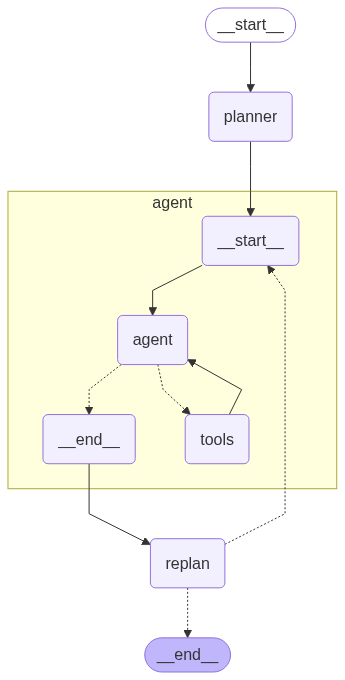

In [13]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [16]:
from loguru import logger

config = {"recursion_limit": 10}
inputs = {"input": "what is the hometown of the mens 2024 Australia open winner?"}
async for event in app.astream(inputs, config=config):
    logger.debug(f"event: {event}")
    for k, v in event.items():
        if k != "__end__":
            logger.info(f"event value: {v}")

2025-06-09 13:58:25.176 | DEBUG    | __main__:<module>:6 - event: {'planner': {'plan': ["Identify the men's singles winner of the 2024 Australian Open tennis tournament.", "Research or find information about the player's hometown.", 'Report the hometown of the identified player.']}}
2025-06-09 13:58:25.179 | INFO     | __main__:<module>:9 - event value: {'plan': ["Identify the men's singles winner of the 2024 Australian Open tennis tournament.", "Research or find information about the player's hometown.", 'Report the hometown of the identified player.']}
2025-06-09 13:59:22.653 | DEBUG    | __main__:<module>:6 - event: {'agent': {'past_steps': [("Identify the men's singles winner of the 2024 Australian Open tennis tournament.", "The men's singles winner of the 2024 Australian Open tennis tournament is Jannik Sinner. According to the information found, Jannik Sinner was born in Innichen, a town in the province of South Tyrol in Northern Italy. He grew up in Sexten, another town in the D

GraphRecursionError: Recursion limit of 10 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT